# Problem Description

Insurance companies take risks over customers. Risk management is a very important aspect of the insurance industry. Insurers consider every quantifiable factor to develop profiles of high and low insurance risks. Insurers collect vast amounts of information about policyholders and analyze the data.

<u>As a Data scientist in an insurance company, you need to analyze the available data and predict whether to sanction the insurance or not</u>

In [1]:
# Imported required packages for analysis and model creation.

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV,SelectKBest,SelectFromModel,RFE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier 

%matplotlib inline

In [2]:
#imported data using pandas library
train_df = pd.read_csv('train.csv')

In [3]:
# One glance at imported data set
train_df.head(10)

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.000000,0.000000,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.000000,0.000000,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.800000,11.880000,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.000000,0.000000,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.000000,0.000000,36,0
5,5959,EPX,Travel Agency,Online,2 way Comprehensive Plan,4,THAILAND,25.000000,0.000000,38,0
6,6031,EPX,Travel Agency,Online,Cancellation Plan,215,UNITED KINGDOM,59.000000,0.000000,36,0
7,8394,JZI,Airlines,Online,Basic Plan,31,VIET NAM,22.000000,7.700000,43,0
8,3017,EPX,Travel Agency,Online,2 way Comprehensive Plan,13,CHINA,48.662699,0.000000,36,1
9,8054,C2B,Airlines,Online,Bronze Plan,10,SINGAPORE,23.258824,5.817294,28,1


In [4]:
# finding metadata info about loaded dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 11 columns):
ID                      52310 non-null int64
Agency                  52310 non-null object
Agency Type             52310 non-null object
Distribution Channel    52310 non-null object
Product Name            52310 non-null object
Duration                52310 non-null int64
Destination             52310 non-null object
Net Sales               52310 non-null float64
Commision (in value)    52310 non-null float64
Age                     52310 non-null int64
Claim                   52310 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


In [5]:
# Some insight's from the data
train_df.describe(include=['O'])  # for DataType as Object

,Agency,Agency Type,Distribution Channel,Product Name,Destination
count,52310,52310,52310,52310,52310
unique,16,2,2,25,97
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
freq,26218,34996,51419,13254,14242


In [6]:
train_df.describe(exclude=['O'])  # for DataType as Numeric

,ID,Duration,Net Sales,Commision (in value),Age,Claim
count,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000
mean,6005.745804,58.256108,48.554673,12.219963,39.555725,0.166699
std,2306.450475,109.138708,60.198589,22.847645,13.762473,0.372710
min,2000.000000,-2.000000,-389.000000,0.000000,0.000000,0.000000
25%,4015.000000,10.000000,19.800000,0.000000,33.000000,0.000000
50%,6002.000000,24.000000,29.500000,0.000000,36.000000,0.000000
75%,8004.000000,57.000000,55.000000,13.380000,43.000000,0.000000
max,10000.000000,4881.000000,682.000000,262.760000,118.000000,1.000000


In [7]:
train_df = train_df.drop(train_df[train_df['Net Sales']<0].index,axis=0)
train_df = train_df.drop(train_df[train_df['Duration']<0].index,axis=0)

# Manchine Learning steps:

    1.Data Pre-Processing & Exploratory Data Analysis
    2.Feature Selection Pipeline
    3.Model Creation
    4.Ensemble Method

## (A) <u>Data Pre-Processing and Exploratory Data Analysis</u>

In [8]:
# Step 1: finding any missing values and data types
def check_data_missing_columns(dataframe):
    data_missing_columns = [col for col in train_df.columns if train_df[col].isnull().sum() > 0]
    if len(data_missing_columns) == 0:
        print("No Data missing from Dataset.")
    else:
        print("Data missing in columns : ",",".join(data_missing_columns))

In [9]:
def drop_duplicate_records(dataframe):
    dataframe.drop_duplicates(keep='first', inplace=True)
    return dataframe

In [10]:
def remove_unwanted_features(dataframe,remove_cols):
    dataframe = dataframe.drop(columns=remove_cols,axis=1)
    return dataframe

In [11]:
# Since Data is not missing now verifying the columns and its type
def get_numeric_and_non_numeric_columns(dataframe):
    numeric_df = dataframe.select_dtypes(include=np.number)
    non_numeric_df = dataframe.select_dtypes(exclude=np.number)
    return numeric_df,non_numeric_df

In [12]:
def check_value_counts(dataframe,cate_cols):
    for col in cate_cols:
        sns.set(style="darkgrid")
        if col == 'Destination':
            sns.set(rc={'figure.figsize':(10,20)})
            ax = sns.countplot(y=col, data=dataframe, orient='h')
        else:
            sns.set(rc={'figure.figsize':(10,10)})
            ax = sns.countplot(x=col,hue='Claim',data=dataframe)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        plt.show()

In [13]:
def find_outliers_from_data(dataframe,num_cols):
    sns.boxplot(data=dataframe.loc[:,num_cols[1:-1]],orient = 'h')
    temp_df = dataframe.ID.to_frame()
    for col in num_cols:
        if col != 'ID' and col != 'Claim':
            temp_df[col] = np.abs(stats.zscore(dataframe[col])) > 3
    temp_df.set_index('ID',inplace=True)
    return temp_df

In [14]:
def remove_outliers_from_data(dataframe,outliers_df):
    outliers_id = []
    group = outliers_df.groupby(list(outliers_df.columns),as_index=False)
    for grp in group.groups:
        outliers_id.extend(list(group.get_group(grp).index))
    outliers = list(set(outliers_id))
    dataframe.drop(outliers,axis=0,inplace=True)
    return dataframe  

In [15]:
def perform_eda_on_loaded_dataset(dataframe):
    dataframe = drop_duplicate_records(dataframe)
    #outliers_df = find_outliers_from_data(dataframe,list(dataframe.select_dtypes(include=np.number).columns))
    #df_wo_outliers = remove_outliers_from_data(dataframe,outliers_df)
    valid_cols_df = remove_unwanted_features(dataframe,['ID'])
    sns.pairplot(data=valid_cols_df,hue='Claim',dropna=True)
    numeric_df, non_numeric_df = get_numeric_and_non_numeric_columns(valid_cols_df.iloc[:,0:-1])
    check_value_counts(valid_cols_df,non_numeric_df.columns)
    plt.show()
    return valid_cols_df

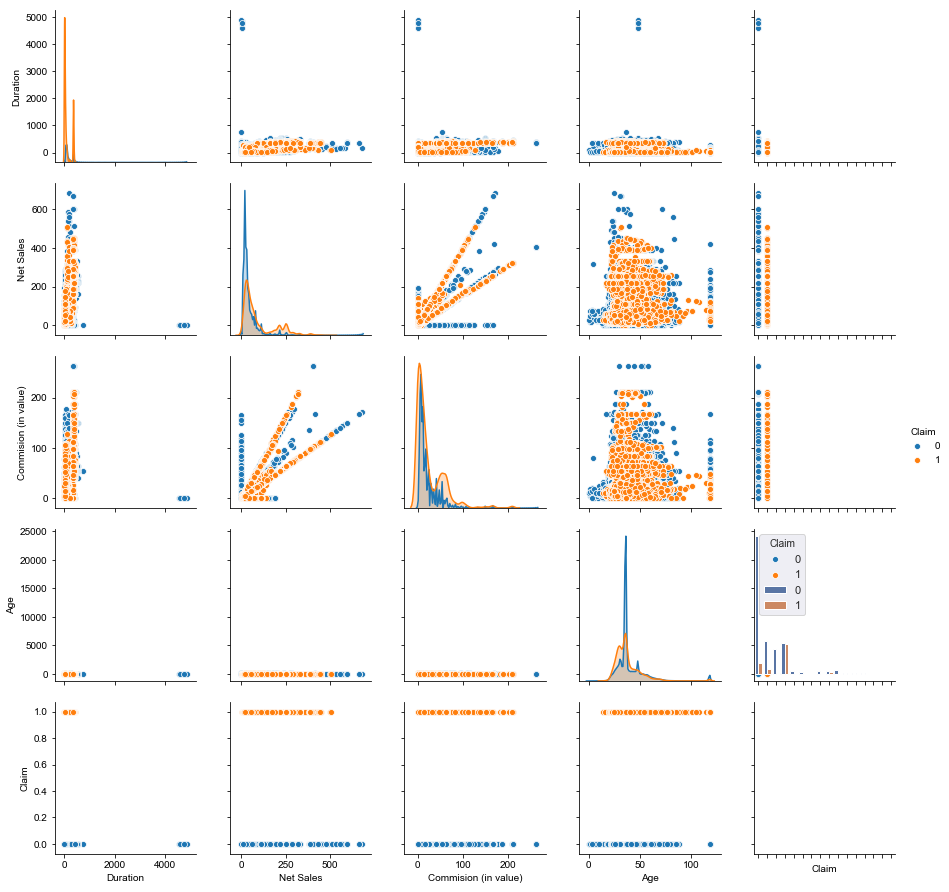

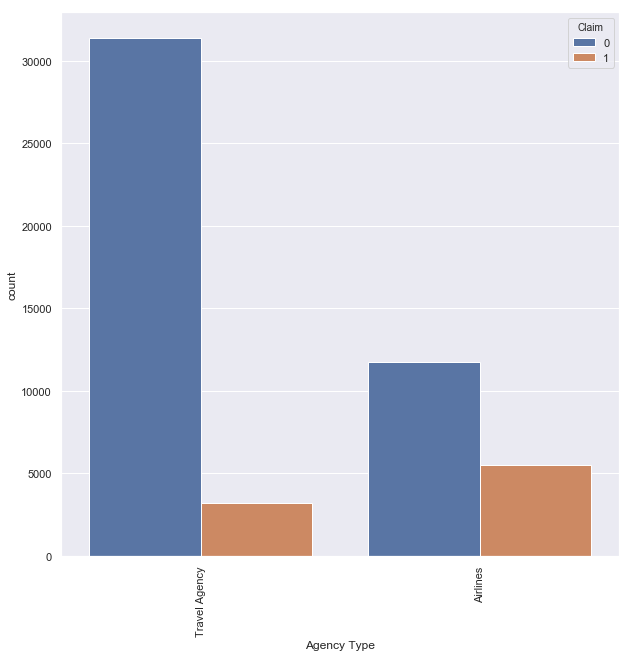

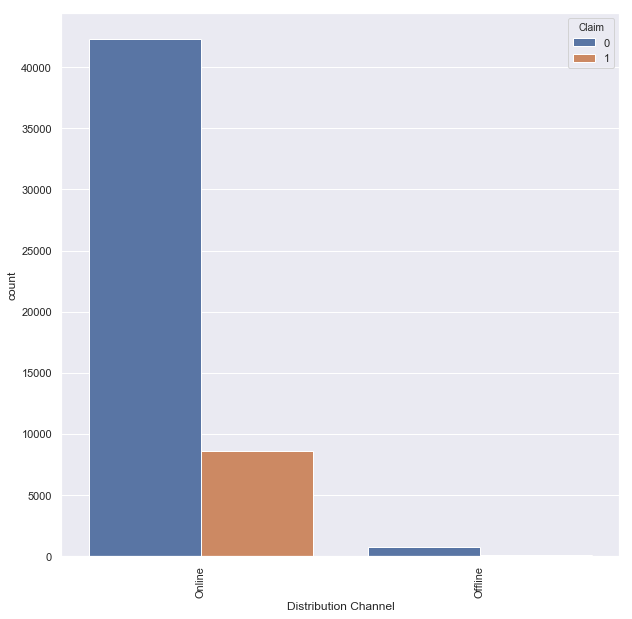

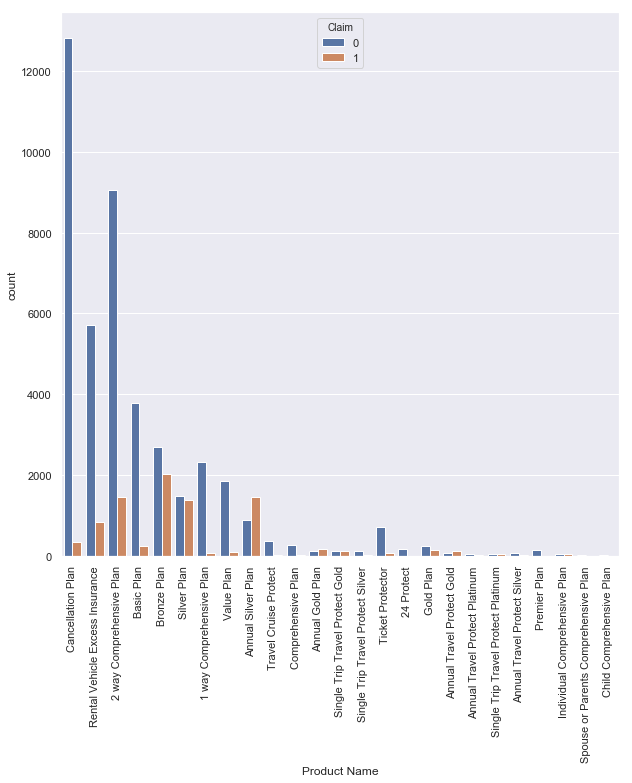

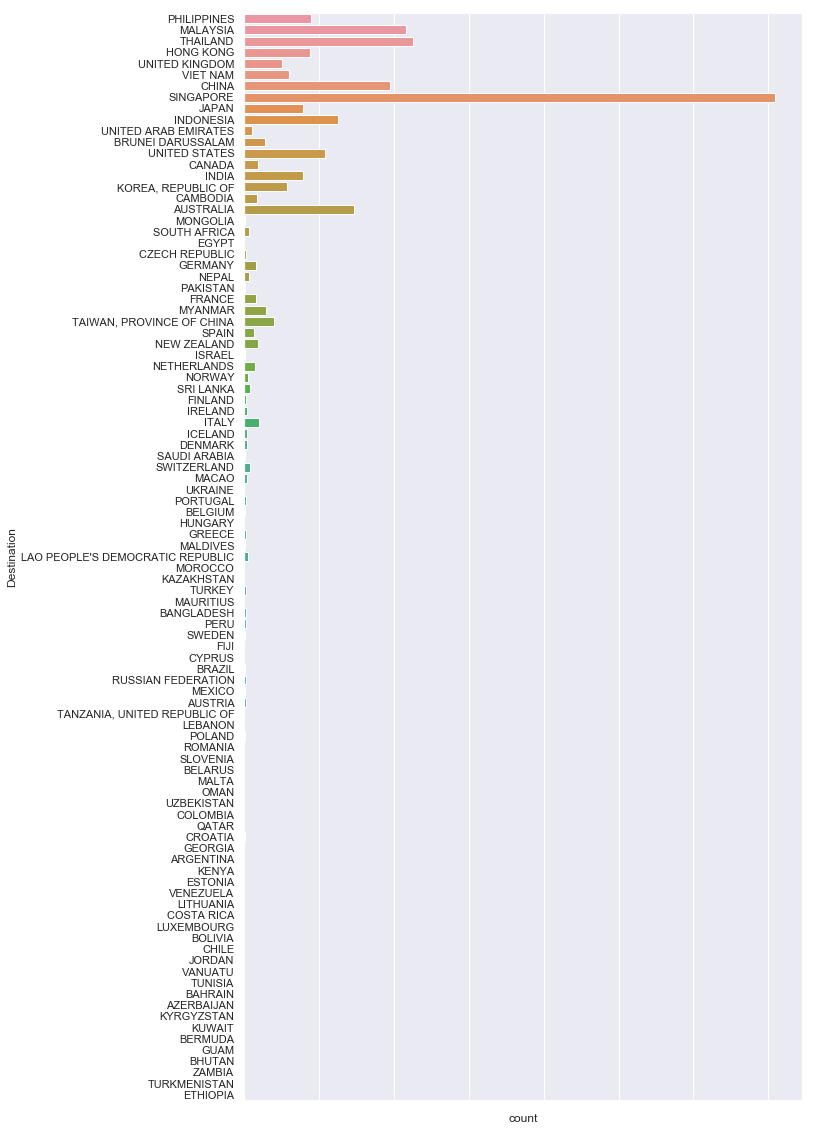

In [16]:
final_df = perform_eda_on_loaded_dataset(train_df)

In [17]:
# Step 2: Determinig the X & Y for the given dataset.
X = final_df.iloc[:,0:-1]
y = final_df.Claim

# Determine X_train,X_test,y_train,y_test
X_train, X_test, y_train, y_test = tts(X,y,test_size=0.23,random_state=42,stratify=y)

print("X_train shape {}".format(X_train.shape))
print("X_test shape {}".format(X_test.shape))


X_train shape (39886, 9)
X_test shape (11915, 9)


## Performing Scaling on numeric columns

In [18]:
numeric_cols = list(X_train.iloc[:,[4,6,7,8]].columns)
print(numeric_cols)

['Duration', 'Net Sales', 'Commision (in value)', 'Age']


In [19]:
standard_scaler = StandardScaler()
standard_scaler.fit(X_train.loc[:,numeric_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
scaled_X_train =  pd.DataFrame(standard_scaler.transform(X_train.loc[:,numeric_cols]),columns=numeric_cols)
scaled_X_test =  pd.DataFrame(standard_scaler.transform(X_test.loc[:,numeric_cols]),columns=numeric_cols)

## Performing One Hot Encoding

In [21]:
cat_cols = list(X_train.iloc[:,[0,1,2,3,5]].columns)

In [22]:
onehot_encoder = OneHotEncoder(sparse=True,handle_unknown='ignore')
onehot_encoder.fit(X_train.iloc[:,[0,1,2,3,5]])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [23]:
ohe_X_train = pd.DataFrame(onehot_encoder.transform(X_train.iloc[:,[0,1,2,3,5]]).toarray())
ohe_X_test = pd.DataFrame(onehot_encoder.transform(X_test.iloc[:,[0,1,2,3,5]]).toarray())

In [24]:
final_X_train = pd.concat([scaled_X_train,ohe_X_train],1)
final_X_test = pd.concat([scaled_X_test,ohe_X_test],1)

In [25]:
print("Final X_train shape = {} and final X_test shape {}".format(final_X_train.shape,final_X_test.shape))

Final X_train shape = (39886, 145) and final X_test shape (11915, 145)


## (B) Feature Selection Techniques

In [26]:
# Estimator initialization for SelectFromModel
rndm_clf = RandomForestClassifier(n_estimators=117,criterion='entropy',random_state=5,class_weight='balanced')

# SelectFromModel is initialize
feat_sel = SelectFromModel(estimator=rndm_clf)

In [27]:
feat_sel.fit(final_X_train,y_train)
features = pd.Series(feat_sel.get_support(),index=final_X_train.columns)
best_features = list(features[features==True].index)

## (C) Model Creation

In [91]:
def print_metric_based_on_y_pred(y_test,y_pred,y_proba):
    print(accuracy_score(y_test,y_pred))
    print("**"*30)
    print(confusion_matrix(y_test,y_pred))
    print("**"*30)
    print(classification_report(y_test,y_pred))
    print("**"*30)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
    # calculate AUC
    auc = roc_auc_score(y_test, y_proba[:,1])
    print('AUC: %.3f' % auc)
    plt.figure(figsize=(8,4))
    plt.plot(fpr, tpr,label="test AUC = {}".format(auc))
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

In [92]:
def run_random_forest(X_train,X_test,y_train,y_test):
    clf = RandomForestClassifier(n_estimators=121,n_jobs=2,criterion='entropy',random_state=7,class_weight='balanced')
    clf.fit(X_train.loc[:,best_features],y_train)
    y_pred = clf.predict(X_test.loc[:,best_features])
    y_proba = clf.predict_proba(X_test.loc[:,best_features])
    return clf,y_pred,y_proba

0.9275702895509862
************************************************************
[[9517  396]
 [ 467 1535]]
************************************************************
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      9913
           1       0.79      0.77      0.78      2002

    accuracy                           0.93     11915
   macro avg       0.87      0.86      0.87     11915
weighted avg       0.93      0.93      0.93     11915

************************************************************
AUC: 0.960


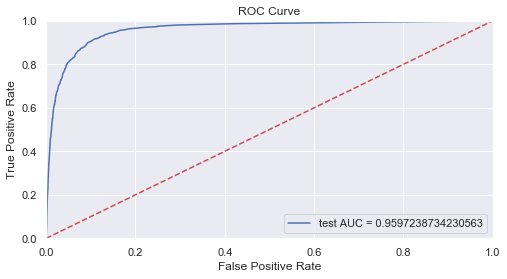

In [93]:
clf, y_pred, y_proba = run_random_forest(final_X_train,final_X_test,y_train,y_test)
print_metric_based_on_y_pred(y_test,y_pred,y_proba)

In [94]:
def run_xgboost(X_train,X_test,y_train,y_test):
    from xgboost import XGBClassifier
    xg_clf = XGBClassifier(booster='gbtree', n_estimators=300, max_depth=110)
    xg_clf.fit(X_train.loc[:,best_features],y_train)
    y_pred = xg_clf.predict(X_test.loc[:,best_features])
    y_proba = xg_clf.predict_proba(X_test.loc[:,best_features])
    return xg_clf,y_pred,y_proba

0.9444397817876626
************************************************************
[[9619  294]
 [ 368 1634]]
************************************************************
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      9913
           1       0.85      0.82      0.83      2002

    accuracy                           0.94     11915
   macro avg       0.91      0.89      0.90     11915
weighted avg       0.94      0.94      0.94     11915

************************************************************
AUC: 0.976


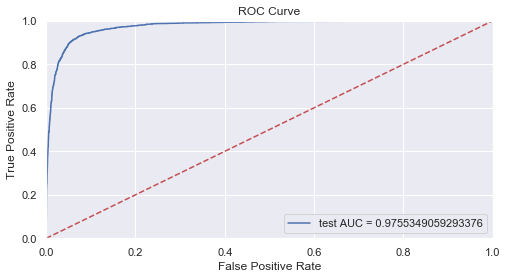

Wall time: 1min 6s


In [95]:
%%time
xgb_clf,y_pred, y_proba = run_xgboost(final_X_train,final_X_test,y_train,y_test)
print_metric_based_on_y_pred(y_test,y_pred,y_proba)

In [33]:
validation_df = remove_unwanted_features(pd.read_csv('test.csv'),['ID'])
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22421 entries, 0 to 22420
Data columns (total 9 columns):
Agency                  22421 non-null object
Agency Type             22421 non-null object
Distribution Channel    22421 non-null object
Product Name            22421 non-null object
Duration                22421 non-null int64
Destination             22421 non-null object
Net Sales               22421 non-null float64
Commision (in value)    22421 non-null float64
Age                     22421 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 1.5+ MB


In [34]:
vStandard_scaler = StandardScaler()
vStandard_scaler.fit(validation_df.loc[:,numeric_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [35]:
scaled_validation_df =  pd.DataFrame(vStandard_scaler.transform(validation_df.loc[:,numeric_cols]),columns=numeric_cols)

In [36]:
scaled_validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22421 entries, 0 to 22420
Data columns (total 4 columns):
Duration                22421 non-null float64
Net Sales               22421 non-null float64
Commision (in value)    22421 non-null float64
Age                     22421 non-null float64
dtypes: float64(4)
memory usage: 700.8 KB


In [37]:
onehot_encoder = OneHotEncoder(sparse=True,handle_unknown='ignore')
onehot_encoder.fit(validation_df.iloc[:,[0,1,2,3,5]])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [38]:
ohe_validation_df = pd.DataFrame(onehot_encoder.transform(validation_df.iloc[:,[0,1,2,3,5]]).toarray())

In [39]:
final_validation_df = pd.concat([scaled_validation_df,ohe_validation_df],1)

In [96]:
final_y_pred = clf.predict(final_validation_df.loc[:,best_features])

In [97]:
def generate_submission(file_name,final_y_pred):
    sample_submission = pd.read_csv(file_name)
    sample_submission.Claim = final_y_pred
    print(sample_submission.Claim.value_counts())
    sample_submission.to_csv('results_1.csv')

In [98]:
generate_submission('sample_submission.csv',final_y_pred)

0    18240
1     4181
Name: Claim, dtype: int64
